In [0]:
import tensorflow  as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input,Dense,SimpleRNN, GRU,LSTM,Flatten,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.preprocessing import StandardScaler

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [0]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [0]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [0]:
#Wrong Process
series = df['close'].values.reshape(-1,1)


In [0]:
#Normalize the data

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()


In [0]:
#build dataset
T=10
D=1
X=[]
Y=[]
for t in range(len(series)-T):
  x= series[t:t+T]
  X.append(x)
  y= series[t+T]
  Y.append(y)

X= np.array(X).reshape(-1,T,1) #N*T*D
Y= np.array(Y)
N= len(X)
print("x.shape:",X.shape,"y.shape:",Y.shape)

x.shape: (1249, 10, 1) y.shape: (1249,)


In [0]:
#auto regressive linear model

i= Input(shape=(T,1))
x= LSTM(5)(i)
x= Dense(1)(x)
model= Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)

#train RNN
r= model.fit(    
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data= (X[-N//2:],Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 1s 28ms/step - loss: 0.2474 - val_loss: 0.3899
Epoch 2/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0175 - val_loss: 0.0303
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0230
Epoch 4/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0271
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0206
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0448
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0203
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0527
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0242
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0309
Epoch 11/80
20/20 

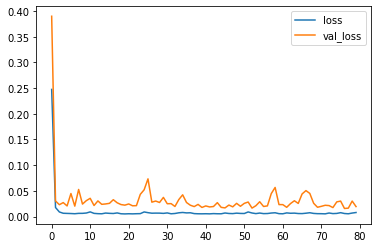

In [0]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

(1249, 1)


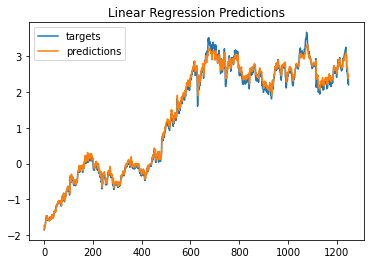

In [0]:
#one step forecast using true targets
#Note: even the one step forecast fails badly

outputs= model.predict(X)
print(outputs.shape)
predictions= outputs[:,0]

plt.plot(Y,label='targets')
plt.plot(predictions,label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

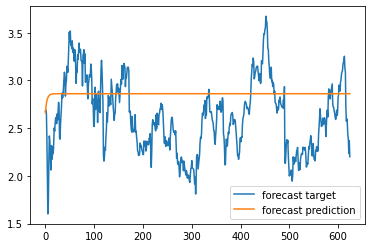

In [0]:
#Multi-Step Forecast

validation_target= Y[-N//2:]
validation_predictions= []

#last train input
last_x= X[-N//2] #1D array of length T

while len(validation_predictions)<len(validation_target):
  p= model.predict(last_x.reshape(1,-1))[0,0] 

  #update prediction_list
  validation_predictions.append(p)

  #make the new input
  last_x= np.roll(last_x,-1)
  last_x[-1]= p

plt.plot(validation_target,label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [0]:
#Correct Process

df['PrevClose'] = df['close'].shift(1) #moving up

#x[t] x[t-1]

In [0]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [0]:
#Return Calculation 
#x[t] = x[t-1] /x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [0]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


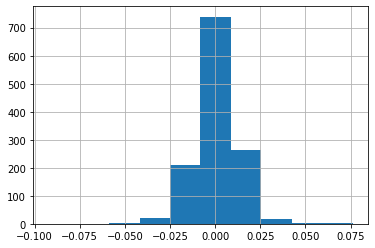

In [0]:
#LSTM to predict Returns
df['Return'].hist()

In [0]:
series = df['Return'].values[1:].reshape(-1,1)

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [0]:
#build dataset
T=10
D=1
X=[]
Y=[]
for t in range(len(series)-T):
  x= series[t:t+T]
  X.append(x)
  y= series[t+T]
  Y.append(y)

X= np.array(X).reshape(-1,T,1) #N*T*D
Y= np.array(Y)
N= len(X)
print("x.shape:",X.shape,"y.shape:",Y.shape)

x.shape: (1248, 10, 1) y.shape: (1248,)


In [0]:
#auto regressive linear model

i= Input(shape=(T,1))
x= LSTM(5)(i)
x= Dense(1)(x)
model= Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01),
)

#train RNN
r= model.fit(    
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data= (X[-N//2:],Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 0s 23ms/step - loss: 0.9879 - val_loss: 1.1514
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9863 - val_loss: 1.1664
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9937 - val_loss: 1.1456
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9831 - val_loss: 1.1523
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9846 - val_loss: 1.1593
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9826 - val_loss: 1.1479
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9835 - val_loss: 1.1571
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9807 - val_loss: 1.1487
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9803 - val_loss: 1.1541
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9802 - val_loss: 1.1472
Epoch 11/80
20/20 

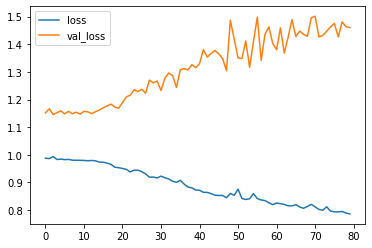

In [0]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

(1248, 1)


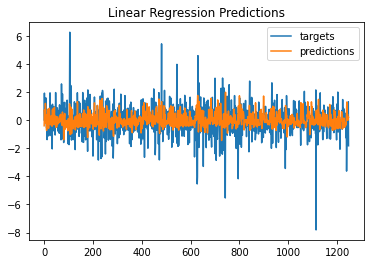

In [0]:
#one step forecast using true targets
#Note: even the one step forecast fails badly

outputs= model.predict(X)
print(outputs.shape)
predictions= outputs[:,0]

plt.plot(Y,label='targets')
plt.plot(predictions,label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

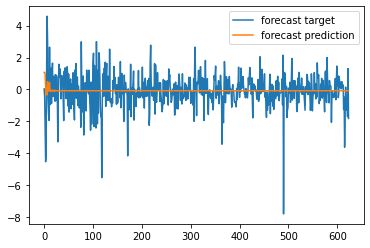

In [0]:
#Multi-Step Forecast

validation_target= Y[-N//2:]
validation_predictions= []

#last train input
last_x= X[-N//2] #1D array of length T

while len(validation_predictions)<len(validation_target):
  p= model.predict(last_x.reshape(1,-1))[0,0] 

  #update prediction_list
  validation_predictions.append(p)

  #make the new input
  last_x= np.roll(last_x,-1)
  last_x[-1]= p

plt.plot(validation_target,label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

#Not a intimidating Result

In [0]:
#3rdModel for Prediction as previous model results were not intimidating

input_data = df[['open','high','low','close','volume']].values
targets = df['Return'].values



In [0]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [0]:
#normalize the inputs

Ntrain = len(input_data)*2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)


In [0]:
#Setup x_train and y_train
x_train = np.zeros((Ntrain,T,D))
y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  x_train[t,:,:] = input_data[t:t+T]
  y_train[t] = (targets[t+T] > 0)
  


In [0]:
#Setup x_test and y_test
x_test = np.zeros((N - Ntrain,T,D))
y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  t = u + Ntrain
  x_test[u,:,:] = input_data[t:t+T]
  y_test[u] = (targets[t+T] > 0)

In [0]:
#make RNN
i= Input(shape=(T,D))
x= LSTM(50)(i)
x= Dense(1, activation = 'sigmoid')(x)
model= Model(i,x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy'],

)

#train RNN
r= model.fit(    
    x_train,y_train, batch_size=32,
    epochs=300,
    validation_data= (x_test,y_test)
)

Epoch 1/300
27/27 [==============================] - 1s 22ms/step - loss: 0.6954 - accuracy: 0.5125 - val_loss: 0.6919 - val_accuracy: 0.5244
Epoch 2/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.5268 - val_loss: 0.6945 - val_accuracy: 0.4927
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5125 - val_loss: 0.6922 - val_accuracy: 0.5146
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.5268 - val_loss: 0.6930 - val_accuracy: 0.4951
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.5280 - val_loss: 0.6930 - val_accuracy: 0.4829
Epoch 6/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6911 - accuracy: 0.5101 - val_loss: 0.7019 - val_accuracy: 0.4951
Epoch 7/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6908 - accuracy: 0.5185 - val_loss: 0.6903 - val_accuracy: 0.5268
Epoch 8/300


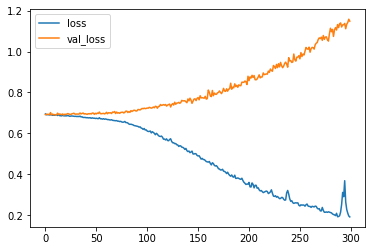

In [0]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

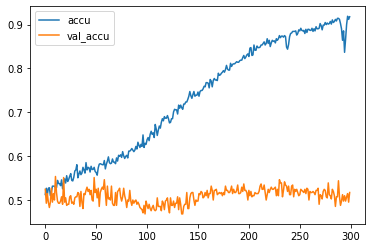

In [0]:
plt.plot(r.history['accuracy'],label='accu')
plt.plot(r.history['val_accuracy'],label='val_accu')
plt.legend()